# <p style="text-align: center;">Exploring Robustness in Dynamic Graphs</p>

<p style="text-align: center;">
<i>
Michael Uftring<br>
Indiana University<br>
INFO-I606-32299 - Network Science<br>
Spring, 2018
</i>
</p>

<p style="padding-left:60px; padding-right:60px">
<b>Abstract.</b> A <i>dynamic graph</i> is a graph "in motion;" it changes over time. A static graph is one which never changes. A dynamic graph may be additive in nature, where vertices or edges are added to the graph. Or, a dynamic graph may be subtractive in nature, where elements are removed. These natures are not mutually exclusive, as a dynamic graph may demonstrate both additive and subtractive behaviors. The <i>robustness</i> of a graph is a measure of how well the graph maintains its structure, form, and integrity when undergoing drastic unexpected change. Common measures of robustness are related to connectivity, path length, and clustering. This project aims to examine robustness in dynamic graphs by constructing models of behavior (both normal and unexpected), and executing them on dynamic graphs. The measure of robustness in these experiments will be effectiveness of a spreading process. The work will be performed in a Jupyter Notebook environment with Gephi for graph visualization.

# 1. Introduction

The objective of this project is to determine if the effectiveness of a *spreading process* can be used as a measure of *robustness* in *dynamic graphs*. The general idea is to model a dynamic graph with some additive behavior and  different detractive behaviors. The detractive processes will be modelled as random failures and targeted attacks. While these structural changes are taking place on the network, a spreading process will be working to "infect" the entire network. The spreading processes is considered effective, or successful, if the entire network becomes infected. The measure indicating success will be expressed as either a rate over time or as a time to saturation. This experimental apporach will be applied to exponential (Erdos-Renyi model) networks, and scale-free (Barabasi-Albert model) networks, and the resuls will be compared.

## 1.1 Dynamic Graphs

A *graph* $G$ is a pair $(V, E)$, where $V$ is a finite set of vertices (or nodes), and $E$ is a set of edges (or links). In an *undirected graph*, each edge is an unordered pair $\left \{ u, v \right \}$ of distinct nodes. In a *directed graph*, each edge is an ordered pair $\left \{ u, v \right \}$ of distinct nodes; this is an indication of a direction which reflects the origin and destination for the relationship represented by the edge. For *weighted graphs*, the notion of functions mapping values to numbers (the weight of a graph component) is added; $f()$: map vertices to numbers, and $g()$: map edges to numbers. The full model can be expressed as: $G = (V, E, f, g)$. 

A *dynamic graph* is obtained when any of the graph components changes over time. [1] Graphs are subject to discrete changes, such as insertions or deletions of vertices or edges, or changes in weights. By dynamic graph we denote a graph that is subject to a sequence of updates. [2]

Dynamic graphs are often typed or classified by the characteristics of their dynamic behavior. Depending on perspective, one of the following categorizations may be employed to assist in characterizing a dynamic graph. 

A component-based typing may be used where the dynamic graph is designated as [1]:

- **node-dynamic**: the set of V varies over time; some nodes may be added or removed. 
- **edge-dynamic**: the set of E varies over time; edges may be added or removed.
- **weight-dynamic**: the weights on vertices or edges changes
- **fully-dynamic**: all aspects of the graph may change

Or, the emphasis may be placed on generally trying to qualify the type of change [3]:

- **incremental**: vertices or edges are only added
- **decremental**: vertices or edges are only removed
- **partially dynamic**: only certain components can be added or removed
- **fully dynamic**: any component can be added, removed, or changed

<font color="red">A common point in all these types and classification is that the system structure - the network topology - varies in time. Furthermore the rate and/or degree of the changes is generally too high to be reasonably modeled in terms of network faults or failures: in these systems changes are not anomalies but rather integral part of the nature of the system.</font> [4]

<img style="width:560px;height:370px;" alt="Embedded Image" src="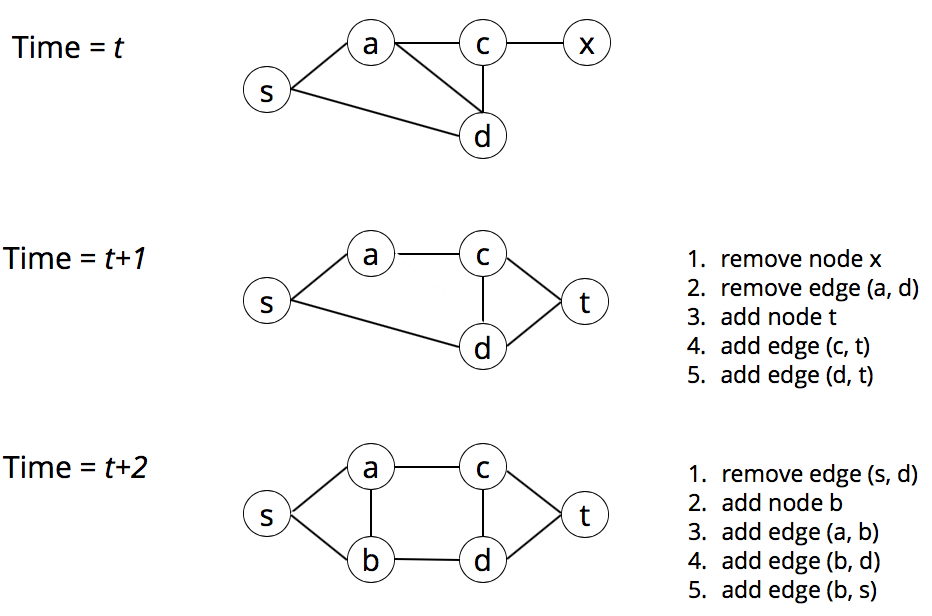
">

<p align="center">**Figure 1 - Example Dynamic Network**. A dynamic graph will change across a period of time. At each measured point in time the amount of change effected, or the catalog of changes, on the graph can be accounted.</p>

### 1.1.1 Models
Some formal models for dynamic graphs have emerged as the field has been studied. What follows is a brief overview or presentation of two that were interesting. These are for informational and study purposes only, and were not an affecting part of the experiment.

#### 1.1.1.1 TVG

Casteigts et al [4] set out with the goal of building a unified model and framework for dynamic networks. The research team explored many papers and journals to gather as much information as they could on the various published models. Ultimately they came to formally define a time-varying graph (TVG) and describe it by:

$$\mathcal{G}=(V, E, \mathcal{T}, \rho, \zeta, \psi, \varphi)$$

where

<table>
    <col width="160">
    <col width="480">
    <tr><td><p align="center">$V$</p></td><td><p align="left">is the set of vertices</p></td></tr>
    <tr><td><p align="center">$E$</p></td><td><p align="left">is the set of edges</p></td></tr>
    <tr><td><p align="center">$\mathcal{T}$</p></td><td><p align="left">is a time span representing the lifetime of the system, where $\mathcal{T} \subseteq \mathbb{T}$</p></td></tr>
    <tr><td><p align="center">$\rho : E \times \mathcal{T} \rightarrow \left \{ 0, 1 \right \}$</p></td><td><p align="left">is a *presence function* that indicates whether an edge is available at a given time</p></td></tr>
    <tr><td><p align="center">$\zeta : E \times \mathcal{T} \rightarrow \mathbb{T}$</p></td><td><p align="left">is a *latency function* that indicates the latency (i.e., weight or cost) of an edge at a given time</p></td></tr>
    <tr><td><p align="center">$\psi : V \times \mathcal{T} \rightarrow \left \{ 0, 1 \right \}$</p></td><td><p align="left">is a node presence function</p></td></tr>
    <tr><td><p align="center">$\varphi : V \times \mathcal{T} \rightarrow \mathbb{T}$</p></td><td><p align="left">is a node latency function</p></td></tr>
</table>


#### 1.1.1.2 Barabasi-Albert (extended)

Acknowledging that the original incarnation of the Barabasi-Albert model had some shortcomings, several extensions to the basic BA model were developed in order to captures a wide range of phenomena that shape the topology of real networks. [7] The extensions are briefly described here; the mathematics and complete description and definition can be found in the reference material. 

- **Initial Attractiveness**: Developed to overcome the fact that nodes with degree = 0 will never gain any edges under *preferential attachment*. This extension adds a constant feature to the probability such that every node has at least a minimal likelihood of some attachment. Given this, nodes with degree = 0 will have some change of gaining a connection to the broader network.
- **Internal Links**: Each cycle of the normal additive process in the BA model will add new nodes to the network and then adds links to those new nodes. In real world scenarios, new links are added betwee existing nodes (not just involving new nodes). So the model was extended such that after the $m$ new nodes are added, $n$ new links are added between existing nodes.
- **Node Deletion**: This capability acknowledges the fact that nodes are removed in real networks.
- **Accelerated Growth**: Instead of growing the number of links linearly with the number of nodes, this extension provides the capability to grow the number of links faster than that rate.
- **Aging**: Nodes, or edges, may naturally age over time and lose "strength" or effectiveness or drive or interest (for example, in the context of social or citation networks). The growth rate expressed as a node's adding of edges may either slow or decline (edges are removed) over time.

### 1.1.2 Representation
Various approaches have been developed for representing dynamic graphs. Given that a dynamic graph is not static, a simple edge list will not be sufficient. The temporal aspect of dynamic graphs must be accounted for, and this is generally achieved in one of two fashions. 

#### 1.1.2.1 Time-ordered snapshots

The first idea is to take a snapshot of the dynamic graph at either uniform periods of time, or after each (or some accumulated amount of) change. The snapshot is simply a static representation of the dynamic graph at some point in time. These snapshots are bound into a collection called a sequence which are ordered by time. The format of the snapshot can be any valid form of representation: e.g., edge list, adjacency matrix. 

The advantage of a sequence of time-ordered snapshots is that the state of the graph can be easily retrieved for any point in time. The main disadvantage of this approach is the amount of storage space required, especially when the graph is large and the number of snapshots increases.

#### 1.1.2.2 Stream of time-ordered events

We first consider that every graph is essentially constructed by a set of ordered steps. At inception the first node in a graph appears, then a second node, and perhaps a link is established between those two initial nodes. The graph then continues to grow in each dimension -- nodes and edges -- until construction is "complete." Up to this point, only the `add` operation has been employed. Beyond the initial contruction phase, the `update` and `delete` operation may be employed based on the behavior in the dynamic graph. Modelling adds, updates, and deletes as events (or commands) is a common operation in software systems, and fits very naturally with dynamic graphs. 

A major advantage of this approach is we are only required to store each event (add, update, delete) in time order, as they occur. This could dramatically reduce the amount of storage space needed, even for large graphs with a lot of dynamic behavior. 

Some disadvantages: if we have no active representation of the graph (in computer memory), then in order to obtain the state of the graph at a given point in time, all events must be played from the beginning of time up to the desired point in time. For a large network with a lot of dynamic activity, this could take a long time. However, if events can be played from a given point in time forward or backward then navigating from one point in time to another could be rather quick. This approach could also permit very interesting active visualization of the graph and the changes occuring.

#### 1.1.2.3 Combined Approach

One further approach would be to combine the stream of time-ordered events with time-ordered snapshots. The goal would be to achieve the benefits of both, and limit the disadvatages as much as possible. As with most algorithms and storage systems, there may be a need to choose between time and space tradeoffs. A perfect dynamic graph system would permit the user to choose the storage and representation approach based on their needs and computer system capacities.

## 1.2 Robustness

> *Many natural and social systems have a remarkable ability to sustain their basic functions even when some of their components fail.*
>
> Barabasi, *Network Science*

Robustness is an indicator of a network's ability to tolerate change. How is robustness or tolerance measured? The simplest approach is to compare the network's ability to function across different scenarios, where one scenario is designated a *baseline* in which the perfect environemnt exists (i.e., no change, or no unexpected behavior). Comparison of other environments to that baseline should indicate how well or how poorly the network performed. The indicator of tolerance for a network can then be distilled down labeled either *tolerant* or *vulnerable*.

Given that a dynamic network is all about change, then the concept of robustness should obviously apply as a first principle. But how can we effectively measure robustness in an ever-changing environment? The answer is to carefully apply the same baselining and scenario-based approach:

- Pick a measure
- Establish a baseline
- Run controlled experiments
- Analyze and compare
- Draw a conclusion

## 1.3 Hypothesis

*Error and attack tolerance of complex networks* [9] reports the generally expected behavior from exponential (Erdos-Renyi model) and scale-free (Barabasi-Albert model) networks when experiencing random failures and when under targeted attack (see Table 1). What about when the network is a dynamic network?

<table>
    <tr><th>Network Type</th><th>Failure</th><th>Attack</th></tr>
    <tr><td>Exponential</td><td>tolerant</td><td>tolerant</td></tr>
    <tr><td>Scale-Free</td><td>tolerant</td><td>vulnerable</td></tr>
</table>

**Table 1 - Expected Tolerance.** The exponential and scale-free networks exhibit the same tolerance to random failures, but different tolerances to targeted attacks.

**Hypothesis 1**

Given that exponential networks are tolerant to random failures and attacks, we suggest that a dynamic network formed from an Erdos-Renyi model and following a growth pattern consistent with that model (in terms of average node degree) will also be tolerant to random failures and attacks.

**Hypothesis 2**

Given that scale-free networks are tolerant to random failures but vulnerable to attacks, we suggest that a dynamic network formed from a Barabasi-Albert model and following a growth pattern consistent with that model (in terms of average node degree) will demonstrate the same tolerances.

In order to test these hypotheses, we use a spreading process to measure the network performance. The effectiveness of the spreading process will be measured in two ways. First, by the rate of spread (number of reached nodes over a period of time). Second, by the total elapsed time (simulated time cycles) to reach saturation.

# 2. Methods

The simulations for these experiments are written in Python and are run in the Jupyter Notebook environment. This affords us with the ability to rapidly try things and make changes. It also provides a means to give immediate visual feedback through plotting with Matplotlib.

NetworkX is used for creating, storing and manipulating the dynamic networks. Other libraries and packages were evaluated, but given the desired approach NetworkX was the best choice. 

The networks are visualized in Gephi in real time as they are constructed and as the dynamic and spreading processes are run. This is achieved using the Gephi Graph Streaming plug-in [13] and refactoring an implementation which utilized the Gephi Graph Streaming API [14].

<img style="float: left; width: 23%; margin-right: 1%; margin-bottom: 0.5em;" src="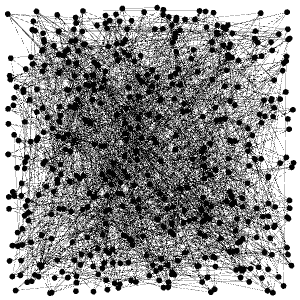
">

<img style="float: left; width: 23%; margin-right: 1%; margin-bottom: 0.5em;" src="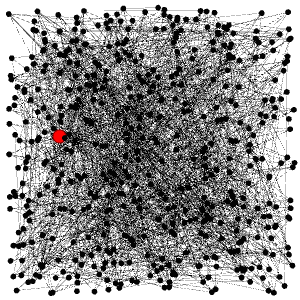
">

<img style="float: left; width: 23%; margin-right: 1%; margin-bottom: 0.5em;" src="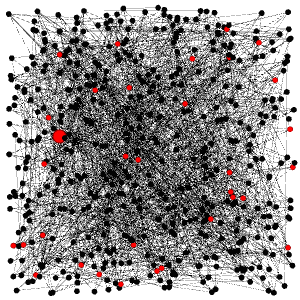
">

<img style="float: left; width: 23%; margin-right: 1%; margin-bottom: 0.5em;" src="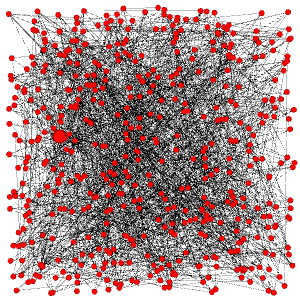
">

**Figure 2 - Dynamic Graph Visualization in Gephi (a-d, left to right).** (a) an Erdos-Renyi graph with 500 nodes has been rendered. (b) the origin of the spreading process has been randomly selected. (c) the spreading process is progressing. (d) the spreading process has completed, infecting all reachable nodes.

The spreading and dynamic processes are implemented as Python classes with functions and methods which perform the additive, detractive, and infection processes. The simulation itself is driven from a Python function which takes as parameters: the graph, the dynamic model, and the maximum number of time cycles (iterations) to run. The simulation will cycle until either the spreading processes completes (i.e., zero nodes are infected in an interation) or the maximum number of time cycles has elapsed.
  
The source code for this project and all results are provided as an appendix to this Jupyter Notebook, and should be executable given the necessary versions of software packages are installed.

# 3. Results

## 3.1 Baseline (Spreading Only)

In the baseline scenario we are running just the spreading process. The graphs have no dynamic activity; no adds, no deletes, nothing changes.

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Baseline Result on Random Network.**

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Baseline Result on Scale-free Network.**

## 3.2 Additive Process Only

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Additive Process Only Result on Random Network.**

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Additive Process Only Result on Scale-free Network.**

## 3.3 Random Detractive Process

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Random Detractive Result on Random Network.**

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Random Detractive Result on Scale-free Network.**

## 3.4 Targeted Detractive Process

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Targeted Detractive Result on Random Network.**

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Targeted Detractive Result on Scale-free Network.**

## 3.5 Invasive Targeted Detractive Process

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Invasive Targeted Detractive Result on Random Network.**

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Invasive Targeted Detractive Result on Scale-free Network.**

## 3.6 Extremely Invasive Targeted Detractive Process

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Extremely Invasive Targeted Detractive Result on Random Network.**

<img alt="Embedded Image" src="data:image/png;base64,">

**Figure N - Extremely Invasive Targeted Detractive Result on Scale-free Network.**

# 4. Discussion

# 5. Conclusion

- what did we observe?

# 6. What's Next?

# References

1. [F. Harary, G. Gupta, *Dynamic Graph Models*, **Mathl. Comput. Modelling**, Vol.25, No.7, pp.79-87, 1997](https://ac.els-cdn.com/S0895717797000502/1-s2.0-S0895717797000502-main.pdf?_tid=23705148-1961-11e8-b0c7-00000aacb35f&acdnat=1519476751_90ed82f52a37b694b2e9b3b658737b04)
1. [C. Demetrescu, P. Italiano, *Dynamic graphs*, **Handbook on Data Structures and Applications**, Chapter 36. Dinesh Mehta and Sartaj Sahni (eds.), CRC Press Series, in Computer and Information Science, January 2005.](https://www.crcpress.com/Handbook-of-Data-Structures-and-Applications/Mehta-Mehta-Sahni/p/book/9781584884354)
1. *Dynamic connectivity*, **Wikipedia**, 2017
1. [A. Casteigts, P. Flocchini, W. Quattrociocchi, N. Santoro, *Time-Varying Graphs and Dynamic Networks*, **Proc. Adhoc-Now'11**, 2010](http://people.scs.carleton.ca/~santoro/Reports/CFQS11.pdf)
1.  [P. Holme, J. Saramäki, *Temporal networks*](https://arxiv.org/abs/1108.1780)
1.  [A. A. Kochkarov, R. A. Kochkarov, and G. G. Malinetskii, *Issues of Dynamic Graph Theory*, **Computational Mathematics and Mathematical Physics**, 2015, Vol. 55, No. 9, pp. 1590–1596, 2015](https://link.springer.com/article/10.1134/S0965542515090080)
1. A. L. Barabasi, *Network Science*, Cambridge University Press, 2016
1. *Shortest path problem*, **Wikipedia**, https://en.wikipedia.org/wiki/Shortest_path_problem
1. R.Albert, H.Jeong, A.L.Barabasi, *Error and attack tolerance of complex networks*, **Nature**, 406, pp. 378-382, 2000
1. [G. Cattaneo, P. Faruolo, U. Ferraro Petrillo, G.F. Italiano, *Maintaining dynamic minimum spanning trees: An experimental study*, **Discrete Applied Mathematics**, Volume 158, Issue 5, Pages 404-425, 6 March 2010](https://www.sciencedirect.com/science/article/pii/S0166218X09003928)
1. [A. Casteigts, S. Dubois, F. Petit, J. M. Robson, *Robustness in Highly Dynamic Networks*, **Computing Research Repository (CoRR)**, 2017](https://arxiv.org/abs/1703.03190)
1. [G. Tanaka, K. Morino, K. Aihara, *Dynamical robustness in complex networks: the crucial role of low-degree nodes*, **Scientific Reports**, volume 2, Article number: 232, 2012](https://www.nature.com/articles/srep00232)
1. [Gephi Graph Streaming plug-in (https://github.com/gephi/gephi/wiki/GraphStreaming)](https://github.com/gephi/gephi/wiki/GraphStreaming)
1. [Y. Yao, *Visualization of Large Dynamic Networks*, Washington State University, 2013](http://www.eecs.wsu.edu/~yyao/DynamicGraph.html)


# Appendix

# Exploring Gephi Graph Streaming
Sources of information and inspiration:

[Gephi - Graph Streaming](https://github.com/gephi/gephi/wiki/GraphStreaming)

[Visualization of Large Dynamic Networks](http://www.eecs.wsu.edu/~yyao/DynamicGraph.html)


## Versions of software, packages, and libraries used:
- Python 3.6
- Jupyter Notebook 5.4.1
- Gephi 0.92
- requests 2.18.4
- numpy 1.14.2
- NetworkX 2.1
- Matplotlib 2.2.2

Notes:
- [NetworkX: Migration guide from 1.X to 2.0](https://networkx.github.io/documentation/stable/release/migration_guide_from_1.x_to_2.0.html)

# Setup and Foundation

## Gephi Graph Streaming plugin

The Gephi Graph Streaming plugin must be installed. To do this, start Gephi and open the Plugins page (Tools -> Plugins). Switch to the Available Plugins panel, find and select Graph Streaming in the list and click Install. Once complete Gephi may need to restart to enable the plugin.

## Turning on Gephi Master (Streaming)

- Run the Gephi application
- Create an empty workspace (File -> New Project, or Workspace -> New)
- Add some nodes and edges to your graph
- Go to the Streaming tab (next to Appearance in the lower left)
- right-click on the “Master Server” and select “Start”

## Start a Graph Stream

You can obtain a stream of graph events by making a `getGraph` request to Gephi. 

`curl "http://localhost:8080/workspace1?operation=getGraph"`

This will not terminate, it is a live stream of Graph events that will run "forever" (that is, until Gephi Streaming is turned off, Gephi terminates, or the client requesting the stream is stopped).

Note: this is not a required step to run this Notebook, nor is it necessary to use the Gephi Graph Streaming API. It is simply an example, and an effective means to observe a Gephi Graph Stream. 

## Gephi API
Below is a simple implementation of the Gephi Graph Streaming API based on [`GephiJsonClient`](http://www.eecs.wsu.edu/~yyao/DirectedStudyII/src/Citation/GephiJsonClient.py); it is modified for newer version of Python and newer version of Gephi. Also it was changed to use the [`requests`](http://docs.python-requests.org/en/master/) library, which also has the benefit of simplifying the implementation significantly.

### Parameters
**Where is Gephi running?**
- `host` = the name of the machine where Gephi is running
- `port` = the HTTP port for the Gephi REST API
- `workspace` = number of the Gephi workspace

In [ ]:
host = "localhost"
port = 8080
workspace = 1

### Build a URL from the parameters
This URL provides access to manipulate the graph in Gephi, note the `operation=updateGraph`. There are other operations which allow querying Gephi for vertex and edge information, and probably others which were not explored in this project.

Each *workspace* in Gephi is a separate space and must be addresed directly; note the `/workspace` part of the URL with a trailing number. Gephi *Graph Streaming* must be turned on for each workspace that we want to acccess.

In [ ]:
def gephiURL(host, port, workspace):
    return "http://{}:{}/workspace{}?operation=updateGraph".format(host, port, workspace)

In [ ]:
url = gephiURL(host, port, workspace)
print(url)

### JSON formatted messages

A JSON document with the specific graph operation is POST'ed to the above URL:
- Vertex operations:
    - `an`: add node
    - `cn`: update node
    - `dn`: delete node
- Edge operations:
    - `ae`: add edge
    - `ce`: update edge
    - `de`: delete edge

Example: *Add Node*
```
{
  "an":{
        "A":{
             "label":"Node A",
             "size":2
            }
  }
}
```

Example: *Add Edge*
```
{
  "ae":{
        "AB":{
              "source":"A",
              "target":"B",
              "directed":false,
              "weight":2
             }
  }
}
```

### Gephi direct access functions

In [ ]:
import requests

def post(content):
    #print(content)
    response = requests.post(url, json=content)
    return response

In [ ]:
def addVertex(node, attr={}):
    content = {"an":{""+node:attr}}
    return post(content)

def removeVertex(node):
    content = {"dn":{""+node:{}}}
    return post(content)

def changeVertex(node, attr={}):
    content = {"cn":{""+node:attr}}
    return post(content)

def addEdge(eid, source, target, directed=False, weight=1.0):
    attributes = {}
    attributes['source'] = source;
    attributes['target'] = target;
    attributes['directed'] = directed;
    attributes['weight'] = weight
    content = {'ae': {eid:attributes}}
    return post(content)

def removeEdge(eid):
    content = {'de':{eid:{}}}
    return post(content)

def changeEdge(eid, attr={}):
    content = {'ce':{eid:attr}}
    return post(content)

### Gephi convenience functions

In [ ]:
def addNode(node):
    return addVertex(str(node), {'label':str(node)})

def addLink(source, target, directed=False, weight=1.0):
    return addEdge("{}-{}".format(str(source), str(target)), str(source), str(target), directed, weight)

def addLinks(links):
    for link in links:
        addLink(link[0], link[1])

def connect(node, neighbors):
    '''
    connect(node, neighbors)
      connect a node to list of neighbors

      Inputs:
        node = the source node
        neighbors = a list of target neighbors
    '''
    for neighbor in neighbors:
        addLink(node, neighbor)

def newNode(node, neighbors):
    '''
    newNode(node, neighbors)
      Create a node node and connect to a list of neighbors

      Inputs:
        node = the new node to be added
        neighbors = a list of neighbors
    '''
    addNode(node)
    connect(node, neighbors)

def deleteNode(node):
    removeVertex(str(node))

BLACK = '#000000'
WHITE = '#ffffff'
RED   = '#ff0000'
GREEN = '#00ff00'
BLUE  = '#0000ff'

def setNodeColor(node, color):
    node = str(node)
    attr = {'color':color}
    return changeVertex(node, attr)

DEFAULT = 10.0
SMALL   = 5.0
MEDIUM  = 15.0
LARGE   = 25.0
XLARGE  = 50.0

def setNodeSize(node, size):
    node = str(node)
    attr = {'size':size}
    return changeVertex(node, attr)


### Create a graph in Gephi

#### custom format -> Gephi

This custom format is a multi-level Python dictionary. The top-level keys represent the vertices of the graph. The values are dictionaries which designate directed edges where the keys are the target vertices and the values are the weights.

In [ ]:
graph = {
    's': {'a': 2, 'b': 1},
    'a': {'s': 3, 'b': 4, 'c': 8},
    'b': {'s': 4, 'a': 2, 'd': 2},
    'c': {'a': 2, 'd': 7, 't': 4},
    'd': {'b': 1, 'c': 11, 't': 5},
    't': {'c': 3, 'd': 5}
}

In [ ]:
'''
gephiGraphCuston(graph)
  Create a graph in Gephi from custom graph format
  
  Inputs:
    graph = graph in custom format
    
  Notes:
    Creates an undirected and unweighted graph, despite the fact 
    that the custom format allows specifying directed and weighted.
'''
def gephiGraphCuston(graph):
    for node in graph:
        response = addNode(node)
    for node in graph:
        for neighbor in graph[node]:
            response = addLink(node, neighbor)

#### NetworkX -> Gephi
This takes a NetworkX `Graph` and will send a series of commands (for all of the nodes and links) to construct and visualize the graph in Gephi.

In [ ]:
'''
gephiGraphNx(graph)
  Create a graph in Gephi from a NetworkX graph
  
  Inputs:
    graph = a NetworkX graph
    
  Notes:
    Creates an undirected and unweighted graph.
'''
def gephiGraphNx(graph):
    for node in graph.nodes():
        result = addNode(str(node))
    for edge in graph.edges():
        source = edge[0]
        target = edge[1]
        result = addLink(str(source), str(target))

## Network Creation functions

In [ ]:
import numpy as np
import networkx as nx

'''
barabasi_albert_graph(n, m=1):
    a function that takes `n` the number of nodes for the graph, 
    and `m` the initial number of nodes, as arguments and returns a networkx 
    graph with a scale-free degree distribution.
'''
def barabasi_albert_graph_without_using_degree(n, m=1):
    # create a complete graph with m initial nodes. 
    # (note: we could use nx.complete_graph() here, but opt to do the creation manually
    # to keep the `type` of the graph created as Graph instead of Complete Graph)
    g = nx.Graph()
    for i in range(m):
        g.add_node(i)
        for j in range(i+1,m):
            g.add_edge(i,j)
    
    # while network has less than n nodes, 
    for i in range(m, n):
        # get the list of edges
        edges = [e for e in g.edges]
        # randomly select m of the edges with equal probability
        selected = np.random.choice(len(edges), m, replace=False)
        # create a new node
        g.add_node(i)
        for s in selected:
            # for each of the selected edges, randomly pick one of the nodes
            linkTo = np.random.choice(edges[s], 1)[0]
            # and add an edge from the new node to that node
            g.add_edge(i, linkTo)
    
    return g

## Plotting and Supporting funtions

### Graph Calculations

In [ ]:
import networkx as nx

def averageDegree(graph):
    return sum([x[1] for x in list(nx.degree(graph))])/len(nx.nodes(graph))

In [ ]:
def probabilityForDegree(N, k):
    return k/(N-1)

In [ ]:
import networkx as nx

def graphDegreeTopN(graph, n=10):
    nodes = sorted(list(nx.degree(graph)), key=lambda x: x[1], reverse=True)
    print("{0:4s} {1:8s} {2:8s}".format("N","Node","Degree"))
    print("---- -------- --------")
    for i in range(n):
        print("{0:4d} {1:8d} {2:8d}".format(i+1,nodes[i][0],nodes[i][1]))

### Plot Degree Distribution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def showDegreeDistribution(graph):
    degrees = sorted([d[1] for d in graph.degree()])
    (v, e, p) = plt.hist(degrees)
    
def showDegreeDistributionWithFit(graph):
    degrees = sorted([d[1] for d in graph.degree()])
    (y, x, p) = plt.hist(degrees)
    y = np.append(y, [0])
    z = np.polyfit(x, y, 3)
    f = np.poly1d(z)
    x_new = np.linspace(x[0], x[-1], 50)
    y_new = f(x_new)
    plt.plot(x_new, y_new, "r")
    plt.xlim([x[0]-1, x[-1] + 1 ])
    plt.show()
    
def showDegreeDistributionLogScale(graph):
    degrees = sorted([d[1] for d in graph.degree()], reverse=True)
    x = np.arange(0, len(degrees))
    plt.plot(x, degrees, "r")
    plt.xscale('log')
    plt.show()
    
def showDegreeDistributionLogLogScale(graph):
    degrees = sorted([d[1] for d in graph.degree()], reverse=True)
    x = np.arange(0, len(degrees))
    plt.loglog(x, degrees, "r")
    plt.show()

# Method

## Overview
The exploration is essentailly these steps: create a graph, run a simulation which performs a spreading process. The exploration will be run on static graphs where this is no dynamic behavior: no nodes or edges are added or removed. This will act as a baseline from which we can compare the results on dynamic graphs.

The exploration will be performed on:
- static graphs: no dynamic graph activity, just a spreading process
- dynamic graphs: spreading with an addative process
- dynamic graphs: spreading with an addative and random detractive process
- dynamic graphs: spreading with an addative and targeted detractive process
- dynamic graphs: spreading with an addative and more invasive targetted detractive process
- dynamic graphs: spreading with a larger addative and extreme invasive targetted detractive process

## Discussion
- what will be the starting point?
- probably a BA graph (Power Law degree distribution)
- what is the normal dynamic nature?
- adding vertices, and edges
- at what rate?
- how will we control time?
- what are the different fault models?
  - what are the targets? (vertices or edges)
  - failure: random target selected
  - attack: specific target selected
- how are the fault models controlled?
- what is the measure for robustness?
- how will we show the robustness measure?

Ultimately I would like to define, model, and run the simulation from the Jupyter Nodebook. The activity should be visible in the Jupyter Notebook (i.e., printing messages about actions taking place), observe the live activity in Gephi, and at periodic intervals export data which can be displayed in Cubix (separately, after the simulation completes).

## Implementation

### Simulation Driver

In [ ]:
import time

def simulate(graph, model, max_iterations = 100):
    spreader = model.spreader()
    grower = model.grower()
    destroyer = model.destroyer()
    
    def init():
        return {'spread':      {'count': {interval: 0}, 'total': {interval: 0}},
                'growth':      {'count': {interval: 0}, 'total': {interval: 0}},
                'destruction': {'count': {interval: 0}, 'total': {interval: 0}}}
    
    def track(tracking, key, count):
        if interval > 0:
            total = tracking[key]['total'][interval-1]
        else:
            total = 0
        tracking[key]['count'][interval] = count
        tracking[key]['total'][interval] = (total + count)
        return

    def spreadingProcess():
        spread = spreader.spread(graph)
        track(tracking, 'spread', spread)
        return spread

    def growingProcess():
        growth = grower.grow(graph)
        track(tracking, 'growth', growth)
        return growth

    def destroyingProcess():
        destruction = destroyer.destroy(graph)
        track(tracking, 'destruction', destruction)
        return destruction

    # start...
    interval = 0
    tracking = init()
    # initial contact to a single 'origin' node
    spread = spreader.spread(graph)
    track(tracking, 'spread', spread)
    # pause a little so we can observe the 'origin' selection
    time.sleep(10)
    
    # run until spreading stops, or the max number of iterations has elapsed
    while (spread != 0) and (interval < max_iterations):
        interval += 1
        # Step 1: run growing
        if grower != None: growth = growingProcess()
        # Step 2: run destruction
        if destroyer != None: destruction = destroyingProcess()
        # Step 3: run spreading
        spread = spreadingProcess()
        # pause so we can observe each iteration's activity
        time.sleep(2)

    return tracking

### Spreading Process

In [ ]:
import networkx as nx

class Spreader:
    contagion='infected'
    indicator=RED
    interval = 0
    
    def __init__(self, contagion='infected', indicator=RED):
        self.contagion = contagion
        self.indicator = indicator

    def config(self):
        print("Spreader() contagion: {} indicator: {}".format(self.contagion, self.indicator))
        
    def infect(self, graph, node, size=DEFAULT):
        graph.nodes[node].update({self.contagion: True})
        setNodeColor(node, self.indicator)
        setNodeSize(node, size)

    def initial(self, graph):
        # add the contagion attribute to all nodes
        nx.set_node_attributes(graph, name=self.contagion, values=False)
        # randomly select the origin
        origin = np.random.choice(list(graph.nodes()), 1)[0]
        self.infect(graph, origin, size=LARGE)
        return 1
    
    def incremental(self, graph, infected):
        self.interval += 1
        count = 0
        # infect any uninfected neighbors of the infected nodes
        for node in infected:
            for neighbor in nx.neighbors(graph, node):
                if not graph.nodes.data()[neighbor][self.contagion]:
                    print("time: {0:4d} spread from: {1} -> {2}".format(self.interval, node, neighbor))
                    self.infect(graph, neighbor)
                    count += 1
        return count
    
    def uninitialized(self, graph):
        nodes = [node[0] for node in filter(lambda x: x[1] == None, list(graph.nodes(data=self.contagion)))]
        for node in nodes:
            graph.nodes[node].update({self.contagion: False})
    
    def spread(self, graph):
        infected = [node[0] for node in filter(lambda x: x[1] == True, list(graph.nodes(data=self.contagion)))]
        if len(infected) == 0:
            return self.initial(graph)
        else:
            self.uninitialized(graph)
            return self.incremental(graph, infected)

### Graph trait for additive and detractive processes

In [ ]:
class Grapher:
    def __init__(self):
        pass
    
    def graphAdd(self, graph, node, edges, color=BLACK, size=DEFAULT):
        self.graphAddNode(graph, node, color, size)
        self.graphAddEdges(graph, edges)
    
    def graphAddNode(self, graph, node, color=BLACK, size=DEFAULT):
        # add node to NetworkX graph
        graph.add_node(node)
        # add node to Gephi, and set color
        addNode(node)
        setNodeColor(node, color)

    def graphAddEdge(self, graph, source, target):
        # add edge to NetworkX graph
        graph.add_edge(source, target)
        # add edge to Gephi
        addLink(source, target)
    
    def graphAddEdges(self, graph, edges):
        # add edges to NetworkX graph
        graph.add_edges_from(edges)
        # add edges to Gephi
        addLinks(edges)
        
    def graphDeleteNode(self, graph, node):
        # delete node from NetworkX graph
        graph.remove_node(node)
        # delete node in Gephi
        deleteNode(node)

### Additive Process

In [ ]:
import numpy as np

class Expander(Grapher):
    interval = 0
    nodes = 0
    links = 0
    next_node = 0
    
    def __init__(self, nodes = 10, links = 10):
        self.nodes = nodes
        self.links = links

    def expand(self, graph):
        self.interval += 0
        nodes = list(graph.nodes())
        if self.next_node == 0:
            self.next_node = max(nodes)
        for i in range(self.nodes + 1):
            self.next_node += 1
            neighbors = np.random.choice(nodes, self.links, replace=False)
            edges = list(zip(np.full(len(neighbors), self.next_node), neighbors))
            self.graphAdd(graph, self.next_node, edges, color=BLUE)
        return self.nodes

class HubCreator(Grapher):
    interval = 0
    number = 3
    threshold = 0.25

    def __init__(self, number = 3, threshold = 0.25):
        self.number = number
        self.threshold = threshold
        
    def create(self, graph):
        self.interval += 0
        created = 0
        # find top `number` of nodes by degree
        # count how many have degree >= threshold?
        # if `count` is less than `number`
        # then create `number` - `count` hubs with degree (`threshold` * graph.number_of_nodes)
        return created
    
class Grower:
    interval = 0
    expander = None
    hubCreator = None
    
    def __init__(self, expander = None, hubCreator = None):
        self.expander = expander
        self.hubCreator = hubCreator

    def grow(self, graph):
        self.interval += 1
        growth = 0
        if self.expander != None: 
            growth += self.expander.expand(graph)
        if self.hubCreator != None:
            growth += self.hubCreator.create(graph)
        return growth

### Detractive Process

In [ ]:
import numpy as np

class Target:
    number = 10
    percent = 0.0
    
    def __init__(self, number=10, percent=0.0):
        self.number = number
        self.percent = percent

class TargetRandomNodes(Target):
    def select(self, graph):
        nodes = list(graph.nodes())
        # randomly select a percent of all nodes, or a fixed number of nodes
        if self.percent > 0.0:
            targets = np.random.choice(nodes, int(self.percent * len(nodes)), replace=False)
        else:
            targets = np.random.choice(nodes, self.number, replace=False)
        return targets

class TargetHighDegreeNodes(Target):
    def select(self, graph):
        # get list of nodes ordered by degree, descending (highest -> lowest)
        nodes = [y[0] for y in sorted(list(nx.degree(graph)), key=lambda x: x[1], reverse=True)]
        # select targetted nodes, starting from the head of the list
        if self.percent > 0.0:
            target = nodes[0:int(self.percent * len(nodes))]
        else:
            target = nodes[0:self.number]
        return target
    
class Destroyer(Grapher):
    interval = 0
    target = None
    
    def __init__(self, target=None):
        self.target = target

    def destroy(self, graph):
        self.interval += 1
        count = 0
        if self.target != None:
            selected = self.target.select(graph)
            for node in selected:
                count += 1
                self.graphDeleteNode(graph, node)
        return count

### Model

In [ ]:
'''
Model

  Contains the three components of the dynamic model
  - Spreader: responsible for the spreading process
  - Grower: responsibile for dynamically growing the graph
  - Destroyer: destroys elements of the graph

'''
class Model:
    _spreader = None
    _grower = None
    _destroyer = None

    def spreader(self):
        return self._spreader
    
    def grower(self):
        return self._grower
    
    def destroyer(self):
        return self._destroyer

In [ ]:
'''
SpreadingOnly

  Provides only a Spreader.
  
'''
class SpreadingOnly(Model):
    def __init__(self, graph = None):
        self._spreader = Spreader()
        self._grower = None
        self._destroyer = None

In [ ]:
'''
AdditiveOnly

  Provides a Spreader, and a Grower with an Expander that will add nodes based
  on the `nodes` parameter, and links based on the `links` parameter or the 
  average degree of the graph.
  
'''
class AdditiveOnly(Model):
    def __init__(self, graph, nodes=20, links=-1):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = None

In [ ]:
'''
AddativeWithFixedRandomDetractive

  Provides a Spreader, and a Grower with an Expander, and also provides a 
  Destroyer that will TargetRandomNodes on a fixed number basis defined 
  by the `remove` parameter.
  
'''
class AddativeWithFixedRandomDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, remove=20):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetRandomNodes(number = remove, percent = 0.0))

In [ ]:
'''
AddativeWithPercentRandomDetractive

  Provides a Spreader, and a Grower with an Expander, and also provides a 
  Destroyer that will TargetRandomNodes on a top-n percentage basis defined 
  by the `percent` parameter.
  
'''
class AddativeWithPercentRandomDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, percent=0.05):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetRandomNodes(number = 0, percent = percent))

In [ ]:
'''
AddativeWithTargetedDetractive

  Provides a Spreader, and a Grower with an Expander, and a Destroyer that will
  TargetHighDegreeNodes by number specified by the `remove` parameter..

'''
class AddativeWithTargetedDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, remove=1):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetHighDegreeNodes(number = remove, percent = 0.0))

In [ ]:
'''
AddativeWithInvasiveDetractive

  Provides a Spreader, and a Grower with an Expander, and a Destroyer that will
  TargetRandomNodes on a top-n percent basis.
   
'''
class AddativeWithInvasiveDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, percent=0.025):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetHighDegreeNodes(number = 0, percent = percent))

In [ ]:
'''
AddativeWithExtremeInvasiveDetractive

  Provides a Spreader, and a Grower with an Expander that has a higher node additive value, 
  and a Destroyer that will TargetRandomNodes with a high top-n percent value.
   
'''
class AddativeWithExtremeInvasiveDetractive(Model):
    def __init__(self, graph, nodes=50, links=-1, percent=0.10):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetHighDegreeNodes(number = 0, percent = percent))

### Results Processing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

class Results:
    results = {}
    data = {}
    
    def __init__(self):
        pass
    
    def store(self, tag, results):
        self.results[tag] = results
        self.data[tag] = self.resultsDataFrame(results)
    
    def showResultsTable(self, tag):
        return self.data[tag]
    
    def showSpreading(self, tag):
        results = self.results[tag]
        x = list(results['spread']['count'].keys())
        y1 = list(results['spread']['count'].values())
        y2 = list(results['spread']['total'].values())
        plt.plot(x, y1, "r--", label='spread')
        plt.plot(x, y2, "b", label='infected')
        plt.xlabel('time')
        plt.ylabel('count')
        plt.legend()
        plt.show()
        
    def resultsDataFrame(self, results):
        df = pd.DataFrame(columns=['time',
                                   'spread_count', 'spread_total',
                                   'growth_count', 'growth_total',
                                   'destruction_count', 'destruction_total'])
        times = list(results['spread']['count'].keys())
        df.time = times
        if len(list(results['spread']['count'].values())) == len(times):
            df.spread_count = list(results['spread']['count'].values())
            df.spread_total = list(results['spread']['total'].values())
        if len(list(results['growth']['count'].values())) == len(times):
            df.growth_count = list(results['growth']['count'].values())
            df.growth_total = list(results['growth']['total'].values())
        if len(list(results['destruction']['count'].values())) == len(times):
            df.destruction_count = list(results['destruction']['count'].values())
            df.destruction_total = list(results['destruction']['total'].values())
        return df

### Graph Creation

In [ ]:
# Erdos-Renyi graph model
class ErdosRenyiGraph:
    N = 500
    p = 0.01

In [ ]:
import networkx as nx

def randomGraph():
    return nx.erdos_renyi_graph(ErdosRenyiGraph.N, ErdosRenyiGraph.p)

In [ ]:
# Barabasi-Albert graph model
class BarabasiAlbertGraph:
    N = 500
    m_o = 7

In [ ]:
def baGraph():
    return barabasi_albert_graph_without_using_degree(BarabasiAlbertGraph.N, BarabasiAlbertGraph.m_o)

### Simulation Parameters and Run-time

In [ ]:
class Simulation:
    max_iterations = 10

In [ ]:
results = Results()

# Exploration

## Static Graphs - spreading process only

### Erdos-Renyi (random) graph

In [ ]:
url = gephiURL(host, port, 1)
tag = "static-er-spreading-only"

In [ ]:
graph1 = randomGraph()

In [ ]:
showDegreeDistributionWithFit(graph1)

In [ ]:
%%time
gephiGraphNx(graph1)

In [ ]:
averageDegree(graph1)

In [ ]:
results.store(tag, simulate(graph1, SpreadingOnly(), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

### Barabasi-Albert graph

In [ ]:
url = gephiURL(host, port, 2)
tag = "static-ba-spreading-only"

In [ ]:
graph2 = baGraph()

In [ ]:
showDegreeDistributionWithFit(graph2)

In [ ]:
%%time
gephiGraphNx(graph2)

In [ ]:
averageDegree(graph2)

In [ ]:
graphDegreeTopN(graph2)

In [ ]:
results.store(tag, simulate(graph2, SpreadingOnly(), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

## Dynamic Graphs - spreading with additive process

### Erdos-Renyi (random) graph

In [ ]:
url = gephiURL(host, port, 3)
tag = "dynamic-er-additive-only"

In [ ]:
graph3 = randomGraph()

In [ ]:
showDegreeDistributionWithFit(graph3)

In [ ]:
%%time
gephiGraphNx(graph3)

In [ ]:
averageDegree(graph3)

In [ ]:
results.store(tag, simulate(graph3, AdditiveOnly(graph3), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

### Barabasi-Albert graph

In [ ]:
url = gephiURL(host, port, 4)
tag = "dynamic-ba-additive-only"

In [ ]:
graph4 = baGraph()

In [ ]:
showDegreeDistributionWithFit(graph4)

In [ ]:
%%time
gephiGraphNx(graph4)

In [ ]:
averageDegree(graph4)

In [ ]:
graphDegreeTopN(graph4)

In [ ]:
results.store(tag, simulate(graph4, AdditiveOnly(graph4), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

## Dynamic Graphs - spreading with addative and random detractive

### Erdos-Renyi (random) graph

In [ ]:
url = gephiURL(host, port, 5)
tag = "dynamic-er-additive-with-random-detractive"

In [ ]:
graph5 = randomGraph()

In [ ]:
showDegreeDistributionWithFit(graph5)

In [ ]:
%%time
gephiGraphNx(graph5)

In [ ]:
averageDegree(graph5)

In [ ]:
results.store(tag, simulate(graph5, AddativeWithFixedRandomDetractive(graph5), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

### Barabasi-Albert graph

In [ ]:
url = gephiURL(host, port, 6)
tag = "dynamic-ba-additive-with-random-detractive"

In [ ]:
graph6 = baGraph()

In [ ]:
showDegreeDistributionWithFit(graph6)

In [ ]:
%%time
gephiGraphNx(graph6)

In [ ]:
averageDegree(graph6)

In [ ]:
graphDegreeTopN(graph6)

In [ ]:
results.store(tag, simulate(graph6, AddativeWithFixedRandomDetractive(graph6), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

In [ ]:
graphDegreeTopN(graph6)

## Dynamic Graphs - addative and targeted detractive

### Erdos-Renyi (random) graph

In [ ]:
url = gephiURL(host, port, 7)
tag = "dynamic-er-additive-with-targeted-detractive"

In [ ]:
graph7 = randomGraph()

In [ ]:
showDegreeDistributionWithFit(graph7)

In [ ]:
%%time
gephiGraphNx(graph7)

In [ ]:
averageDegree(graph7)

In [ ]:
graphDegreeTopN(graph7)

In [ ]:
results.store(tag, simulate(graph7, AddativeWithTargetedDetractive(graph7), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

In [ ]:
graphDegreeTopN(graph7)

### Barabasi-Albert graph

In [ ]:
url = gephiURL(host, port, 8)
tag = "dynamic-ba-additive-with-targeted-detractive"

In [ ]:
graph8 = baGraph()

In [ ]:
showDegreeDistributionWithFit(graph8)

In [ ]:
%%time
gephiGraphNx(graph8)

In [ ]:
averageDegree(graph8)

In [ ]:
graphDegreeTopN(graph8)

In [ ]:
results.store(tag, simulate(graph8, AddativeWithTargetedDetractive(graph8), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

In [ ]:
graphDegreeTopN(graph8)

## Dynamic Graphs - addative and invasive detractive

### Erdos-Renyi (random) graph

In [ ]:
url = gephiURL(host, port, 9)
tag = "dynamic-er-additive-with-invasive-detractive"

In [ ]:
graph9 = randomGraph()

In [ ]:
showDegreeDistributionWithFit(graph9)

In [ ]:
%%time
gephiGraphNx(graph9)

In [ ]:
averageDegree(graph9)

In [ ]:
graphDegreeTopN(graph9)

In [ ]:
results.store(tag, simulate(graph9, AddativeWithInvasiveDetractive(graph9), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

In [ ]:
graphDegreeTopN(graph9)

### Barabasi-Albert graph

In [ ]:
url = gephiURL(host, port, 10)
tag = "dynamic-ba-additive-with-invasive-detractive"

In [ ]:
graph10 = baGraph()

In [ ]:
showDegreeDistributionWithFit(graph10)

In [ ]:
%%time
gephiGraphNx(graph10)

In [ ]:
averageDegree(graph10)

In [ ]:
graphDegreeTopN(graph10)

In [ ]:
showDegreeDistributionLogScale(graph10)

In [ ]:
results.store(tag, simulate(graph10, AddativeWithInvasiveDetractive(graph10), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

In [ ]:
graphDegreeTopN(graph10)

In [ ]:
showDegreeDistributionLogScale(graph10)

## Dynamic Graphs - addative and extremely invasive detractive

### Erdos-Renyi (random) graph

In [ ]:
url = gephiURL(host, port, 11)
tag = "dynamic-er-additive-with-extremely-invasive-detractive"

In [ ]:
graph11 = randomGraph()

In [ ]:
print(nx.info(graph11))

In [ ]:
showDegreeDistributionWithFit(graph11)

In [ ]:
%%time
gephiGraphNx(graph11)

In [ ]:
graphDegreeTopN(graph11)

In [ ]:
results.store(tag, simulate(graph11, AddativeWithExtremeInvasiveDetractive(graph11), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

In [ ]:
print(nx.info(graph11))

In [ ]:
showDegreeDistributionWithFit(graph11)

In [ ]:
graphDegreeTopN(graph11)

### Barabasi-Albert graph

In [ ]:
url = gephiURL(host, port, 12)
tag = "dynamic-ba-additive-with-extremely-invasive-detractive"

In [ ]:
graph12 = baGraph()

In [ ]:
print(nx.info(graph12))

In [ ]:
showDegreeDistributionWithFit(graph12)

In [ ]:
%%time
gephiGraphNx(graph12)

In [ ]:
graphDegreeTopN(graph12)

In [ ]:
showDegreeDistributionLogScale(graph12)

In [ ]:
results.store(tag, simulate(graph12, AddativeWithExtremeInvasiveDetractive(graph12), Simulation.max_iterations))

In [ ]:
results.showResultsTable(tag)

In [ ]:
results.showSpreading(tag)

In [ ]:
print(nx.info(graph12))

In [ ]:
showDegreeDistributionWithFit(graph12)

In [ ]:
graphDegreeTopN(graph12)

In [ ]:
showDegreeDistributionLogScale(graph12)